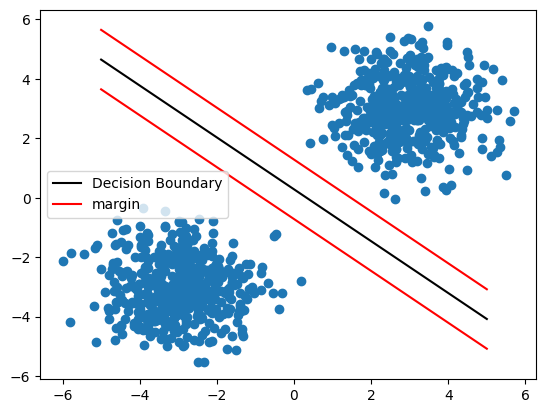

In [1]:
# Q2. (e) Theory of Hard-Margin Support Vector Machines

import matplotlib.pyplot as plt
import numpy as np
toy = np.load('../data/toy-data.npz')
toy_training =toy["training_data"]
plt.scatter(toy_training[:, 0], toy_training[:, 1])

# plot decision boundary
w = np.array([-0.4528, -0.5190])
b = 0.1471
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y, 'k', label='Decision Boundary')

# plot margin
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1] - 1
plt.plot(x, y, 'r', label='margin')

x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1] + 1
plt.plot(x, y, 'r')
plt.legend()
plt.show()

In [2]:
# Q3 (a) Data Partitioning and shuffle
def partition(data, validation_size):
    """
    Partition the input training data and labels into training and validation sets.

    Parameters:
    - data (dict): A dictionary containing keys "training_data" and "training_labels".
    - validation_size (int): The size of the validation set (number of samples).

    Returns:
    list: a list 
        - "train_data": The training data array after shuffling.
        - "train_labels": The corresponding training labels after shuffling.
        - "validate_data": The validation data array after shuffling.
        - "validate_labels": The corresponding validation labels after shuffling.

    """
    # Seed the random number generator for reproducibility
    np.random.seed(150)

    # Get the training data and labels from the input dictionary
    sample_data = data["training_data"]
    sample_label = data["training_labels"]
    sample_size = data["training_data"].shape[0]

    # Shuffle the indices using random permutation
    index_shuffled = np.random.permutation(sample_size)

    #fancy indices
    # Split the data and labels into training and validation sets based on the specified size
    train_data = sample_data[index_shuffled[validation_size:]]
    train_labels = sample_label[index_shuffled[validation_size:]]

    validate_data = sample_data[index_shuffled[:validation_size]]
    validate_labels = sample_label[index_shuffled[:validation_size]]

    # Return a list containing the shuffled training and validation data and labels
    return [train_data, train_labels, validate_data, validate_labels]

# partition mnist data
mnist = np.load('../data/mnist-data.npz')
mnist_train_data, mnist_train_labels, mnist_validate_data, mnist_validate_label = partition(mnist, 10000)

# partition spam data
spam = np.load('../data/spam-data.npz')
spam_train_data, spam_train_labels, spam_validate_data, spam_validate_label = partition(spam, int(spam["training_data"].shape[0] * 0.2))

In [3]:
# Q3 (b) Evaluate metric
def accuracy(predict_label, validate_label):
    """
    Calculate accuracy of predictions.

    Parameters:
    - predict_label (numpy.ndarray): Array of predicted labels.
    - validate_label (numpy.ndarray): Array of true labels.

    Returns:
    float: Accuracy, represented as the ratio of correct predictions to the total number of elements.
    """
    # Get the number of elements in the input arrays
    size = predict_label.shape[0]
    
    # Initialize a counter for correct predictions
    count = 0
    
    # Iterate through each element in the arrays
    for i in range(size):
        # Check if the predicted label matches the true label
        if predict_label[i] == validate_label[i]:
            # Increment the counter for correct predictions
            count += 1
    
    # Calculate and return the accuracy as the ratio of correct predictions to the total number of elements
    return count / size

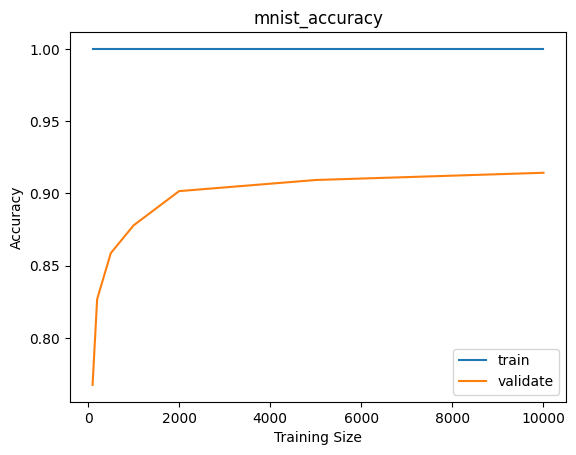

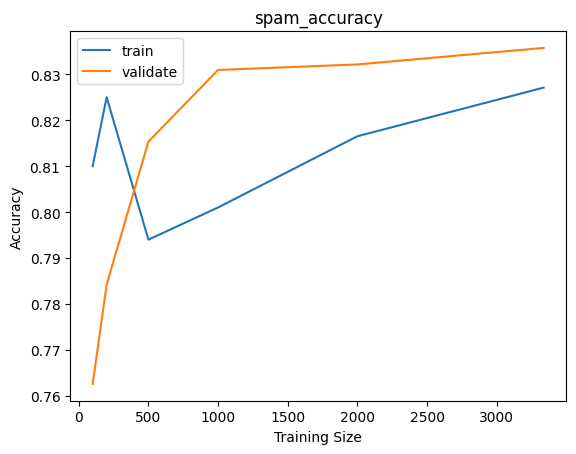

In [4]:
# Q4 Train a linear SVM on the spam and MNIST datasets.
from sklearn.svm import SVC

# Create a linear Support Vector Classifier (SVC)
svc_linear = SVC(kernel='linear')

def train(training_size_arr, train_data, train_labels, validate_data, validate_labels, title):
    """
    Train a linear Support Vector Classifier (SVC) on different training sizes and plot the accuracy.

    Parameters:
    - training_size_arr (list): List of training sizes to iterate over.
    - train_data (numpy.ndarray): Training data array.
    - train_labels (numpy.ndarray): Training labels array.
    - validate_data (numpy.ndarray): Validation data array.
    - validate_labels (numpy.ndarray): Validation labels array.
    - title (str): Tile for the plot.

    Returns:
    None
    """

    # Lists to store accuracy values for plotting
    y_plot_validate = []
    y_plot_train = []

    # Iterate over different training sizes
    for training_size in training_size_arr:
        # Fit the linear SVC on the current training size
        svc_linear.fit(train_data[:training_size], train_labels[:training_size])

        # Predict labels on the validation set
        predict_label = svc_linear.predict(validate_data[:])
        # Calculate accuracy on the validation set and store in the list
        validate_accuracy = accuracy(predict_label, validate_labels)
        y_plot_validate.append(validate_accuracy)

        # Predict labels on the current training set
        train_predict_label = svc_linear.predict(train_data[:training_size])
        # Calculate accuracy on the training set and store in the list
        train_accuracy = accuracy(train_predict_label, train_labels[:training_size])
        y_plot_train.append(train_accuracy)

    # Plot the accuracy for different training sizes
    plt.figure()
    plt.plot(training_size_arr, y_plot_train, label="train")
    plt.plot(training_size_arr, y_plot_validate, label="validate")
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
        
    # Display the plot
    plt.show()

# Q4 (a) SVM on mnist
mnist_training_size_arr = [100, 200, 500, 1000, 2000, 5000, 10000]
# train for mnist
train(mnist_training_size_arr , mnist_train_data.reshape(-1, 28 * 28), mnist_train_labels, mnist_validate_data.reshape(-1, 28 * 28), mnist_validate_label , "mnist_accuracy")

# Q4 (b) SVM on spam 
spam_training_size_arr = [100, 200, 500, 1000, 2000, spam_train_data.shape[0]]
train(spam_training_size_arr, spam_train_data, spam_train_labels, spam_validate_data, spam_validate_label , "spam_accuracy")

In [6]:
# Q5 Hyper tuning

def tune(training_size, train_data, train_labels, validate_data, validate_labels, C_values):
    """
    Tune the hyperparameter C for a linear Support Vector Classifier (SVC).

    Parameters:
    - training_size (int): Size of the training set.
    - train_data (numpy.ndarray): Training data array.
    - train_labels (numpy.ndarray): Training labels array.
    - validate_data (numpy.ndarray): Validation data array.
    - validate_labels (numpy.ndarray): Validation labels array.
    - C_values (list): List of C values to iterate over.

    Returns:
    float: The best value of C that maximizes accuracy on the validation set.
    """

    # Initialize variables to track the best accuracy and corresponding C value
    best_accuracy = 0
    best_accuracy_C = C_values[0]

    # Iterate over different C values
    for c in C_values:
        # Create a linear SVC with the current C value
        svc_linear = SVC(kernel='linear', C=c)
        
        # Fit the SVC on the training set
        svc_linear.fit(train_data[:training_size], train_labels[:training_size])
        
        # Predict labels on the validation set
        predict_label = svc_linear.predict(validate_data[:])
        
        # Calculate accuracy on the validation set
        validate_accuracy = accuracy(predict_label, validate_labels)
        
        # Update the best accuracy and corresponding C value if the current accuracy is higher
        if validate_accuracy > best_accuracy:
            best_accuracy = validate_accuracy
            best_accuracy_C = c
        
        # Print the accuracy for the current C value
        print(validate_accuracy, c)

    # Return the best value of C that maximizes accuracy on the validation set
    return best_accuracy_C

# find the best c for mnist is 5e-07
mnist_C_values =  [0.00000005, 0.0000005, 0.000005, 0.00005, 0.0005, 0.005, 0.05, 0.5]
best_mnist_c = tune(10000, mnist_train_data.reshape(-1, 28 * 28), mnist_train_labels, mnist_validate_data.reshape(-1, 28 * 28), mnist_validate_label, mnist_C_values)
print("best c for mnist is " + str(best_mnist_c))

print("\n")
# find the best c for spam is 50 
spam_C_values = [0.0005, 0.005, 0.05, 0.5, 5, 50, 500, 5000]
best_spam_c = tune(int(spam_train_data.shape[0] * 0.2), spam_train_data, spam_train_labels, spam_validate_data, spam_validate_label, spam_C_values)
print("best c for spam is " + str(best_spam_c))

0.9177 5e-08
0.9303 5e-07
0.9251 5e-06
0.9154 5e-05
0.9143 0.0005
0.9143 0.005
0.9143 0.05
0.9143 0.5
best c for mnist is 5e-07


0.750599520383693 0.0005
0.7757793764988009 0.005
0.7949640287769785 0.05
0.8249400479616307 0.5
0.8285371702637889 5
0.8333333333333334 50
0.8333333333333334 500
0.8333333333333334 5000
best c for spam is 50


In [9]:
# Q6 K-Fold Cross-Validation
def tune_k_fold(training_size, data, k, C_values, is_minst):
    """
    Tune the hyperparameter C for a linear Support Vector Classifier (SVC) using K-Fold Cross-Validation.

    Parameters:
    - training_size (int): Size of the training set.
    - data (dict): A dictionary containing keys "training_data" and "training_labels".
    - k (int): The number of folds for K-Fold Cross-Validation.
    - C_values (list): List of C values to iterate over.
    - is_minst (bool): A flag indicating whether the data is in MNIST format.

    Returns:
    float: The best value of C that maximizes average accuracy across folds.
    """

    # Set a seed for reproducibility
    np.random.seed(150)

    # Extract data and labels from the input dictionary
    sample_data = data["training_data"]
    if is_minst:
        sample_data = sample_data.reshape(-1, 28 * 28)
    sample_label = data["training_labels"]
    sample_size = data["training_data"].shape[0]

    # Shuffle the indices using random permutation
    index_shuffled = np.random.permutation(sample_size)

    # Calculate the subset size for each fold
    sub_set_size = sample_size // k

    # Initialize variables to track the best accuracy and corresponding C value
    best_accuracy_c = C_values[0]
    best_accuracy = 0

    # Iterate over different C values
    for c in C_values:
        # Create a linear SVC with the current C value
        svc_linear = SVC(kernel='linear', C=c)

        # Initialize variable to store average accuracy across folds
        average_accuracy = 0

        # Iterate over folds for K-Fold Cross-Validation
        for fold in range(k):
            validate_start = fold * sub_set_size
            validate_end = (fold + 1) * sub_set_size

            # Extract validation data and labels
            validate_data = sample_data[index_shuffled[validate_start:validate_end]]
            validate_label = sample_label[index_shuffled[validate_start:validate_end]]

            # Extract training data and labels by excluding the validation set
            train_data = sample_data[np.concatenate((index_shuffled[0: validate_start], index_shuffled[validate_end:]))]
            train_labels = sample_label[np.concatenate((index_shuffled[0: validate_start], index_shuffled[validate_end:]))]

            # Fit the linear SVC on the training set
            svc_linear.fit(train_data[:training_size], train_labels[:training_size])

            # Predict labels on the validation set
            predict_label = svc_linear.predict(validate_data[:])

            # Calculate accuracy on the validation set and accumulate for average
            average_accuracy += accuracy(predict_label, validate_label)

        # Calculate average accuracy across folds
        average_accuracy /= k

        # Print average accuracy for the current C value
        print(average_accuracy, c)

        # Update the best accuracy and corresponding C value if the current accuracy is higher
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_accuracy_c = c

    # Return the best value of C that maximizes average accuracy across folds
    return best_accuracy_c

# find the best c for mnist is 5e-07
best_mnist_c = tune_k_fold(10000, mnist, 5, mnist_C_values, True)
print("best c for mnist is " + str(best_mnist_c))
print("\n")
# find the best c for spam is 500 
best_spam_c = tune_k_fold(int(spam_train_data.shape[0] * 0.2), spam, 5, spam_C_values, False)
print("best c for spam is " + str(best_spam_c))

0.91745 5e-08
0.9295166666666667 5e-07
0.9217000000000001 5e-06
0.91075 5e-05
0.9107166666666668 0.0005
0.9107166666666668 0.005
0.9107166666666668 0.05
0.9107166666666668 0.5
best c for mnist is 5e-07


0.7172661870503597 0.0005
0.7453237410071943 0.005
0.7709832134292566 0.05
0.7971223021582734 0.5
0.7997601918465227 5
0.8071942446043165 50
0.8091127098321342 500
0.8091127098321342 5000
best c for spam is 500


In [15]:
# Q7 Kaggle, I figure use rbf for spam since have higer accuracy for spam I aslo added a couple of feature in feature.py by find high occurence word in spam that 
# does not occur frequently in ham

import os
import csv

# generate cvs for mnist, c = 0.0000005 has the best accuracy according to the prev part
mnist_test_data = mnist["test_data"].reshape(-1, 28 * 28)
svc_linear = SVC(kernel='linear', C=0.0000005)
svc_linear.fit(mnist_train_data.reshape(-1, 28 * 28)[:20000], mnist_train_labels[:20000])

predict_label = svc_linear.predict(mnist_test_data[:])
data = [{"Id": i+1, "Category": label} for i, label in enumerate(predict_label)]
csv_file_path = os.path.join(os.path.split(os.getcwd())[0], "mnist_kaggle.csv")

fields = ["Id", "Category"]

# Writing to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)

    # Write the header
    writer.writeheader()

    # Write the data
    writer.writerows(data)

# generate cvs for spam , c = 500  has the best accuracy according to the prev part
spam_test_data = spam["test_data"]

svc_linear = SVC(kernel='rbf', C=50)
svc_linear.fit(spam_train_data[:], spam_train_labels[:])
predict_label = svc_linear.predict(spam_test_data[:])
data = [{"Id": i+1, "Category": label} for i, label in enumerate(predict_label)]


csv_file_path = os.path.join(os.path.split(os.getcwd())[0], "spam_kaggle.csv")


# Writing to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)

    # Write the header
    writer.writeheader()

    # Write the data
    writer.writerows(data)